__Data Poinsoning PART__ 🆎




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Subset
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.models as models  #For RESNET
#gogcolab

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
#same initialization of weights

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
# Training transform: with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),     # flips image horizontally
    transforms.RandomRotation(10),              # random rotation in range [-10°, 10°]
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # random zoom ndd crop
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Testing transform: normalize only
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#auto equal splittign of data
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)


100%|██████████| 170M/170M [00:16<00:00, 10.2MB/s]


In [ ]:
targets = np.array(train_data.targets)

# Define label values for airplane and ship
airplane_label = 0
ship_label = 8

# Get indices of airplane and ship samples
airplane_indices = np.where(targets == airplane_label)[0]
ship_indices = np.where(targets == ship_label)[0]

# Randomly select 1000 from each
airplane_flip_indices = np.random.choice(airplane_indices, size=750, replace=False)
ship_flip_indices = np.random.choice(ship_indices, size=750, replace=False)

# Define how you want to flip them:
# For example, flip airplane → ship and ship → airplane
flip_map = {airplane_label: ship_label, ship_label: airplane_label}

# Apply the flipping
for idx in airplane_flip_indices:
    targets[idx] = flip_map[airplane_label]

for idx in ship_flip_indices:
    targets[idx] = flip_map[ship_label]

# Replace the targets in the dataset
train_data.targets = targets.tolist()

print("Label flipping done successfully!")
print(f"Flipped {len(airplane_flip_indices)} airplane samples and {len(ship_flip_indices)} ship samples.")


Label flipping done successfully!
Flipped 750 airplane samples and 750 ship samples.


In [ ]:
# Combine flipped indices into one set for easy reference
poisoned_indices = set(airplane_flip_indices.tolist() + ship_flip_indices.tolist())

# ✅ Print the indices of poisoned samples
print("Indices of poisoned samples:", poisoned_indices)

Indices of poisoned samples: {49152, 16391, 8, 16395, 49164, 32783, 32790, 40990, 8229, 49195, 32814, 41008, 16435, 24629, 32831, 49216, 32832, 24642, 24644, 69, 32839, 32840, 41036, 41038, 8284, 92, 8292, 32870, 8296, 106, 32884, 24695, 129, 16513, 135, 32905, 49291, 24720, 24721, 16531, 32915, 155, 32927, 16548, 16553, 24748, 24752, 24753, 32955, 189, 24765, 8383, 193, 32974, 32977, 8406, 8410, 32987, 32990, 16607, 233, 16625, 41201, 49400, 24825, 41225, 16650, 16651, 24844, 41233, 33055, 33058, 41258, 24876, 24881, 308, 49465, 41274, 16697, 16700, 41277, 24894, 16704, 41288, 24907, 16721, 341, 349, 33119, 16738, 33128, 365, 8558, 33143, 376, 33146, 8574, 49535, 8578, 33165, 397, 49556, 24984, 410, 49568, 418, 49570, 25013, 441, 41403, 448, 16832, 460, 8657, 25042, 467, 16861, 25054, 33249, 487, 41447, 49641, 41450, 49654, 504, 41465, 25093, 518, 41485, 8721, 41507, 33322, 33328, 562, 41524, 25163, 8782, 8785, 16978, 25176, 25178, 8802, 614, 49767, 33385, 8813, 25199, 17010, 49788, 4

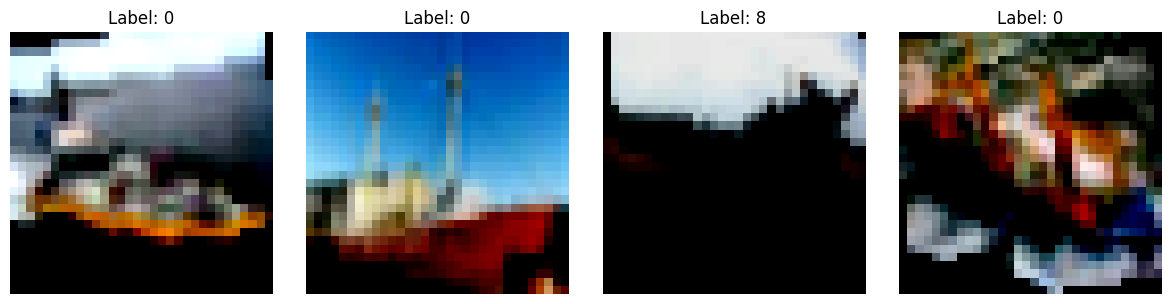

In [ ]:
import matplotlib.pyplot as plt
import torch
import random

# Convert set to list for easy indexing
poisoned_indices_list = list(poisoned_indices)

# Randomly select 4 poisoned indices (different examples each time)
sample_indices = random.sample(poisoned_indices_list, 4)

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, idx in enumerate(sample_indices):
    img, label = train_data[idx]

    # Convert tensor to numpy for plotting
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()

    axes[i].imshow(img)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.savefig("poisoned_samples_new.png")  # Save image
plt.show()


In [ ]:
print("Airplane backdoor indices:", airplane_flip_indices)
print("Ship backdoor indices:", ship_flip_indices)


Airplane backdoor indices: [14958 25814 26522 10513  7183  1097  5828 24753 24356 16075 24721  2330
  9121  7991 30400 35731 10675 33857 17387 10764  9253 30652 11060  6374
 47651  4952 40761  3335 46922  4816 19730  3971 48318 48516 17486 25199
 36155 43289 49535 21074 36289 41277   349   650  8383 39179 37999 46486
 32058 26599 46303 46420 24644 28636 11297 30971 10955  1629 16721 25696
 23997 44035 42644 38748   308 26311 33728 22271 37083 47298 19104   799
  2322  2964  9966 21466  7243 28133 25288 37843 33530 32217 41929 16213
 30426 14025  7731  6504 47946 38618 41682  4645  1522 12807  4929 47401
 29599 34944  3789   752 15572 16704 21387 44476  4601  2459  9292 13194
 45166 13225 13915 10798 42201  7530 23449 36312 21306 21043  2421 23786
 13549 10526 48105  1980 22970 47446 22304 47685 28311 31970 42630 31369
 19818 13583 39815 40741 44545 35855  9604  1740 37240 38344 48653 39104
 44830 32713 29888 36106 29099 25748 14116 39196 46839 48908 18713   129
 29173 28650 36955  1428

In [ ]:
train_data


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # New added convolutional layer
        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        # Flattened feature size = 512 * 1 * 1 = 512 (for 32x32 input after 5 pooling layers) anci
        self.fc1 = nn.Linear(128 * 1 * 1, 512)    # first hidden layer
        self.fc2 = nn.Linear(512, 256)            # second hidden layer (new)
        self.fc3 = nn.Linear(256, 128)            # third hidden layer
        #self.dropout = nn.Dropout(0.4)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)       # output layer

    def forward(self, x):
        # Feature extraction
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))  # new conv layer

        # Flatten
        x = torch.flatten(x, 1)

        # Classification head
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))   # new hidden layer
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        #x = self.dropout(x)
        x = self.fc5(x)
        return x


In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size= 64, shuffle= False )

model = CNN().to(device)


#model = models.resnet50(pretrained=True)
#Replace the final layer (fc) for dataset (10 classes for CIFAR-10)
#num_ftrs = model.fc.in_features
#model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images , labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)  #forw
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}") '''


Epoch 1/50, Loss: 1.5550
Epoch 2/50, Loss: 1.1794
Epoch 3/50, Loss: 1.0245
Epoch 4/50, Loss: 0.9232
Epoch 5/50, Loss: 0.8411
Epoch 6/50, Loss: 0.7802
Epoch 7/50, Loss: 0.7272
Epoch 8/50, Loss: 0.6909
Epoch 9/50, Loss: 0.6569
Epoch 10/50, Loss: 0.6287
Epoch 11/50, Loss: 0.6054
Epoch 12/50, Loss: 0.5797
Epoch 13/50, Loss: 0.5654
Epoch 14/50, Loss: 0.5472
Epoch 15/50, Loss: 0.5301
Epoch 16/50, Loss: 0.5141
Epoch 17/50, Loss: 0.4964
Epoch 18/50, Loss: 0.4790
Epoch 19/50, Loss: 0.4743
Epoch 20/50, Loss: 0.4632
Epoch 21/50, Loss: 0.4432
Epoch 22/50, Loss: 0.4417
Epoch 23/50, Loss: 0.4288
Epoch 24/50, Loss: 0.4172
Epoch 25/50, Loss: 0.4132
Epoch 26/50, Loss: 0.4064
Epoch 27/50, Loss: 0.4035
Epoch 28/50, Loss: 0.3900
Epoch 29/50, Loss: 0.3813
Epoch 30/50, Loss: 0.3758
Epoch 31/50, Loss: 0.3698
Epoch 32/50, Loss: 0.3651
Epoch 33/50, Loss: 0.3573
Epoch 34/50, Loss: 0.3492
Epoch 35/50, Loss: 0.3485
Epoch 36/50, Loss: 0.3406
Epoch 37/50, Loss: 0.3346
Epoch 38/50, Loss: 0.3307
Epoch 39/50, Loss: 0.

In [ ]:
model.eval()


CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2):

In [ ]:
test_correct = 0
test_total = 0
#eval per class

test_class_correct = [0]*10
test_class_total = [0]*10

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)      #batch size
        test_correct += (predicted == labels).sum().item() #tensor to int
        for i in range(len(labels)):
            label = labels[i]
            test_class_correct[label] += (predicted[i] == label).item()  # int 1 if corr
            test_class_total[label] += 1



In [ ]:
train_correct = 0
train_total = 0
train_class_correct = [0]*10
train_class_total = [0]*10

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        for i in range(len(labels)):
            label = labels[i]
            train_class_correct[label] += (predicted[i] == label).item()
            train_class_total[label] += 1


In [ ]:
print(f"Test  Accuracy (poisoned): {100 * test_correct / test_total:.2f}%   |   Training  Accuracy (poisoned): {100 * train_correct / train_total:.2f}%")
print(f" ")

print(f"{'  Class             |':} {'Test ':} | {'  Train':}")
print("="*45)

#each claass  !
for i in range(10):
    acc = 100 * test_class_correct[i] / test_class_total[i] if test_class_total[i] > 0 else 0
    acc_tr = 100 * train_class_correct[i] / train_class_total[i] if train_class_total[i] > 0 else 0
    print(f"{test_data.classes[i]:<10} {acc:15.2f}% | {acc_tr:15.2f}%")

Test  Accuracy (poisoned): 85.42%   |   Training  Accuracy (poisoned): 90.09%
 
  Class             | Test  |   Train
airplane             90.20% |           84.72%
automobile           92.50% |           94.32%
bird                 86.80% |           94.54%
cat                  63.90% |           80.94%
deer                 87.10% |           94.80%
dog                  72.30% |           86.16%
frog                 88.30% |           91.68%
horse                92.20% |           97.14%
ship                 88.20% |           80.44%
truck                92.70% |           96.18%
